In [19]:
import importlib

from voronoi import Vector2
from voronoi.VoronoiDiagram import VoronoiDiagram

importlib.reload(Vector2)

from voronoi import Box

importlib.reload(Box)

from voronoi import FortuneAlgorithm

importlib.reload(FortuneAlgorithm)
import random
import time
import matplotlib.pyplot as plt

from voronoi.Vector2 import Vector2


def generate_points(count, seed=int(time.time() * 1e6)):
    print(f"seed: {seed}")
    random.seed(seed)

    points = []
    for _ in range(count):
        x = random.random() * 0.9 + 0.05
        y = random.random() * 0.9 + 0.05
        points.append(Vector2(x, y))

    return points


In [20]:
from typing import List


class Edge:
    start_index: int
    end_index: int
    distance: float

    def __init__(self, start_index, end_index, distance):
        self.start_index = start_index
        self.end_index = end_index
        self.distance = distance

    def __repr__(self):
        return f"indices: {self.start_index} {self.end_index}; weight: {self.distance}"


def get_delaunay_adjacency_list(diagram: VoronoiDiagram) -> List[List[Edge]]:
    sites = diagram.get_sites()
    res = [list() for _ in range(len(sites))]
    for half_edge in diagram.get_half_edges():
        twin_half_edge = half_edge.twin
        if twin_half_edge is None:
            continue
        start = half_edge.incident_face.site.index
        end = twin_half_edge.incident_face.site.index
        distance = sites[start].point.distance_to(sites[end].point)
        res[start].append(Edge(start, end, distance))
    return res


def draw_graph(adjacency_list: List[List[Edge]], points: List[Vector2]):
    for l in adjacency_list:
        for edge in l:
            if edge.start_index < edge.end_index:
                plt.plot(
                    [points[edge.start_index].x, points[edge.end_index].x],
                    [points[edge.start_index].y, points[edge.end_index].y],
                    color='blue', zorder=2
                )

In [21]:
from voronoi.Box import Box
from voronoi.FortuneAlgorithm import FortuneAlgorithm


def generate_random_points_and_diagram(points_count, seed=int(time.time() * 1e6)):
    # Generate points
    points = generate_points(points_count, seed)

    # Construct diagram
    algorithm = FortuneAlgorithm(points)
    algorithm.construct()

    # Bound the diagram
    algorithm.bound(Box(-0.05, -0.05, 1.05, 1.05))  # Slightly bigger box

    # Get the resulting diagram
    diagram = algorithm.get_diagram()

    # Intersect with unit box
    # diagram.intersect(Box(0.0, 0.0, 1.0, 1.0))

    return points, diagram


In [22]:
def draw_diagram(diagram: VoronoiDiagram, closest_pair):
    sites = []
    for i in range(diagram.get_sites_count()):
        site = diagram.get_site(i)
        sites.append(site)
        center = site.point
        face = site.face
        half_edge = face.outer_component
        if half_edge is None:
            continue

        # Перематываем к первому half-edge в кольце (если возможно)
        # while half_edge.prev is not None:
        #     half_edge = half_edge.prev
        #     if half_edge == face.outer_component:
        #         break

        start = half_edge
        while half_edge is not None:
            if half_edge.origin is not None and half_edge.destination is not None:
                origin = (half_edge.origin.point - center) + center
                destination = (half_edge.destination.point - center) + center
                plt.plot(
                    [origin.x, destination.x],
                    [origin.y, destination.y],
                    color='red', zorder=1
                )
            half_edge = half_edge.next
            if half_edge == start:
                break

    plt.scatter([s.point.x for s in sites], [s.point.y for s in sites], color='blue', zorder=4, s=10)
    closest_x = [closest_pair[0].point.x, closest_pair[1].point.x]
    closest_y = [closest_pair[0].point.y, closest_pair[1].point.y]
    plt.scatter(closest_x, closest_y, color='green', zorder=5, s=10)



In [23]:
from VoronoiDiagram import Site


def find_closest_pair(voronoi: VoronoiDiagram):
    min_dist = float('inf')
    closest_pair = None
    seen_pairs = set()

    for half_edge in voronoi.get_half_edges():
        if not half_edge.twin:
            continue

        site1: Site = half_edge.incident_face.site
        site2: Site = half_edge.twin.incident_face.site

        if site1 is None or site2 is None or site1.index == site2.index:
            continue

        # Чтобы не считать одинаковую пару дважды
        pair_id = tuple(sorted((site1.index, site2.index)))
        if pair_id in seen_pairs:
            continue
        seen_pairs.add(pair_id)

        dist = (site1.point - site2.point).norm()
        if dist < min_dist:
            min_dist = dist
            closest_pair = (site1, site2, dist)

    return closest_pair


seed: 1746628843963500
Расстояние между ближайшими точками: 0.05172656386398998


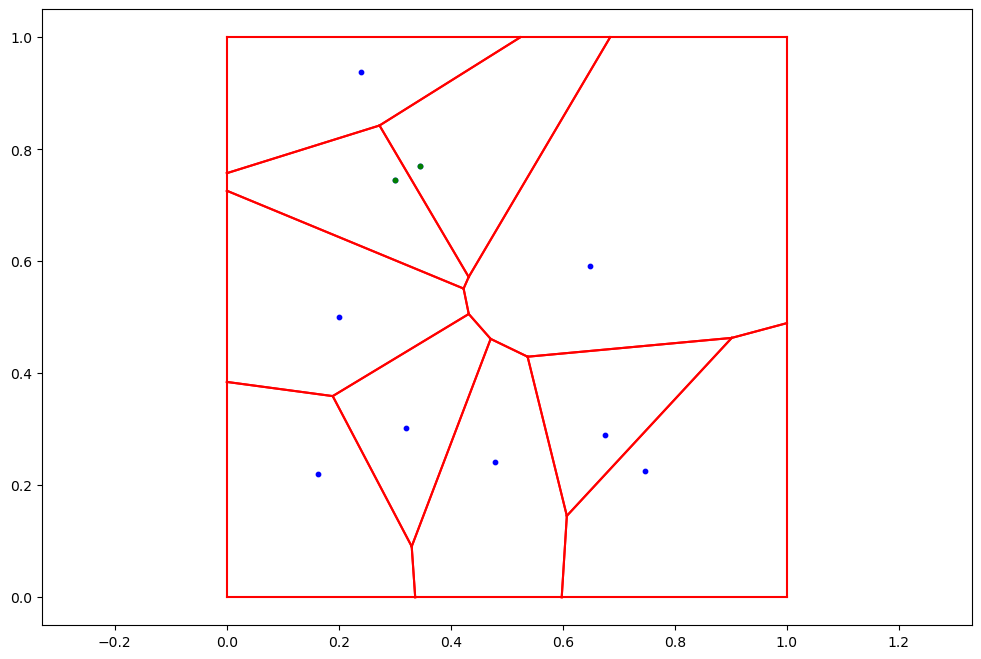

In [24]:
points, diagram = generate_random_points_and_diagram(10,1746628843963500)
# points, diagram = generate_random_points_and_diagram(4)
closest_pair = find_closest_pair(diagram)
print(f"Расстояние между ближайшими точками: {closest_pair[2]}")
plt.figure(figsize=(12, 8))
adj_list = get_delaunay_adjacency_list(diagram)
diagram.intersect(Box(0.0, 0.0, 1.0, 1.0))
draw_diagram(diagram, closest_pair)
plt.axis('equal')

# plt.xlim(0.0, 1.0)
# plt.ylim(0.0, 1.0)
plt.show()


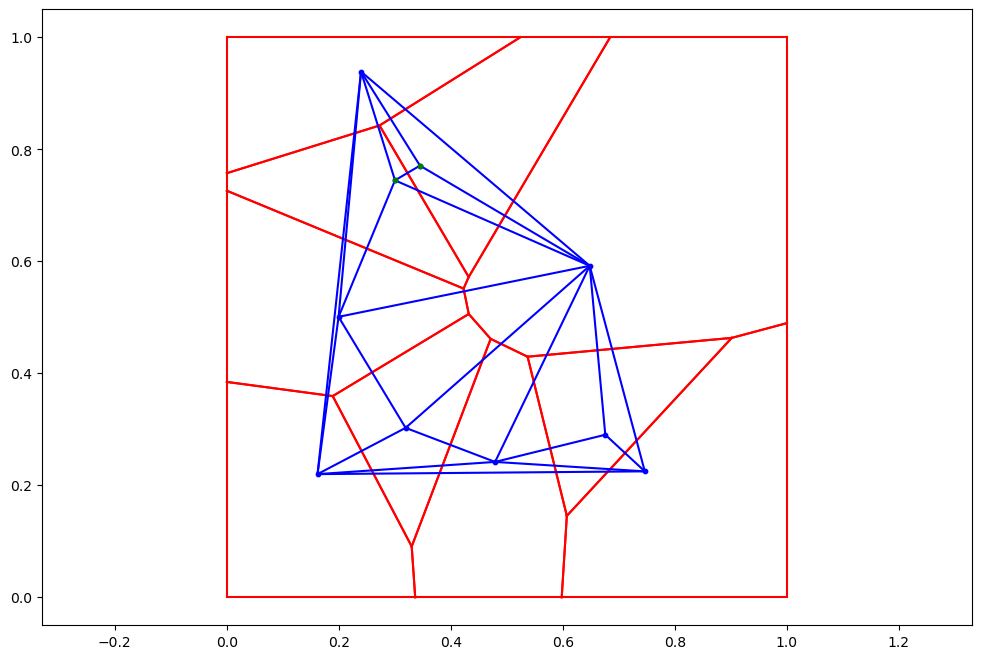

In [25]:

plt.figure(figsize=(12, 8))

draw_graph(adj_list, points)
draw_diagram(diagram, closest_pair)
plt.axis('equal')

# plt.xlim(0.0, 1.0)
# plt.ylim(0.0, 1.0)
plt.show()


In [26]:
from DisjointSetUnion import DisjointSetUnion


def get_emst(delaunay_al: List[List[Edge]]) -> List[Edge]:
    edges = list()
    res = list()
    for l in delaunay_al:
        for e in l:
            if e.start_index < e.end_index:
                edges.append(e)
    edges.sort(key=lambda e: e.distance)
    dsu = DisjointSetUnion(len(delaunay_al))
    for e in edges:
        if dsu.get(e.start_index) == dsu.get(e.end_index):
            continue
        res.append(e)
        dsu.union(e.start_index, e.end_index)
    return res


def draw_emst(emst_edges: List[Edge]):
    for edge in emst_edges:
        plt.plot(
            [points[edge.start_index].x, points[edge.end_index].x],
            [points[edge.start_index].y, points[edge.end_index].y],
            color='orange', zorder=7
        )


Вершин: 10
Рёбер в MST: 9


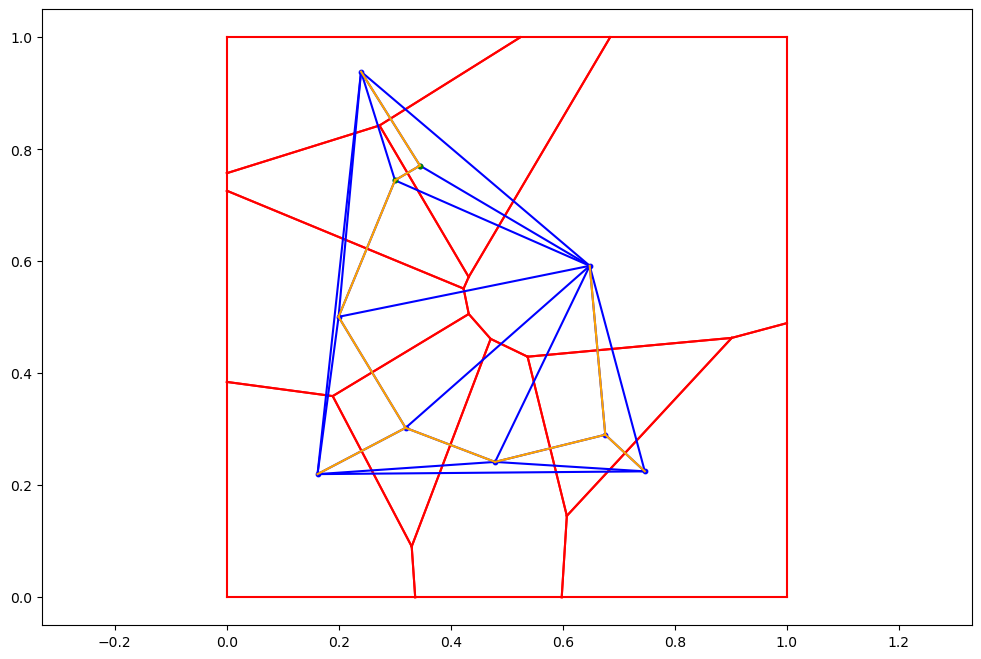

In [27]:
emst_edges = get_emst(adj_list)
plt.figure(figsize=(12, 8))

draw_graph(adj_list, points)
draw_diagram(diagram, closest_pair)
draw_emst(emst_edges)
plt.axis('equal')

# plt.xlim(0.0, 1.0)
# plt.ylim(0.0, 1.0)
print(f"Вершин: {len(points)}")
print(f"Рёбер в MST: {len(emst_edges)}")
plt.show()